In [1]:
#importing necessary libraries
import pandas as pd
import glob
import os
import warnings
import time
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
# importing custom scripts for different functions
sys.path.append('scripts')  # add scripts to path




# Ignore warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("combined.csv")
data.head()

,Commodity,Classification,Grade,Sex,Market,Wholesale,Retail,Supply Volume,County,Date
0,Banana (Ripening),-,-,-,Mukuyu Market,-,50.00/Kg,NaN,Muranga,2026-02-11
1,Banana (Ripening),-,-,-,Mulot,70.00/Kg,100.00/Kg,1500.0,Bomet,2026-02-11
2,Banana (Ripening),-,-,-,Kitale Municipality Market,80.00/Kg,100.00/Kg,6000.0,Trans-Nzoia,2026-02-11
3,Banana (Ripening),-,-,-,Kerugoya,20.00/Kg,40.00/Kg,300.0,Kirinyaga,2026-02-10
4,Banana (Ripening),-,-,-,Bondeni,80.00/Kg,100.00/Kg,5000.0,Trans-Nzoia,2026-02-10


In [3]:
data.isnull().sum()

Commodity             0
Classification        0
Grade                 0
Sex                   0
Market                0
Wholesale             0
Retail                0
Supply Volume     17775
County               19
Date                  0
dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57010 entries, 0 to 57009
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Commodity       57010 non-null  object 
 1   Classification  57010 non-null  object 
 2   Grade           57010 non-null  object 
 3   Sex             57010 non-null  object 
 4   Market          57010 non-null  object 
 5   Wholesale       57010 non-null  object 
 6   Retail          57010 non-null  object 
 7   Supply Volume   39235 non-null  float64
 8   County          56991 non-null  object 
 9   Date            57010 non-null  object 
dtypes: float64(1), object(9)
memory usage: 4.3+ MB


In [5]:
data.duplicated().sum()

np.int64(4259)

In [6]:
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52751 entries, 0 to 52750
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Commodity       52751 non-null  object 
 1   Classification  52751 non-null  object 
 2   Grade           52751 non-null  object 
 3   Sex             52751 non-null  object 
 4   Market          52751 non-null  object 
 5   Wholesale       52751 non-null  object 
 6   Retail          52751 non-null  object 
 7   Supply Volume   36539 non-null  float64
 8   County          52743 non-null  object 
 9   Date            52751 non-null  object 
dtypes: float64(1), object(9)
memory usage: 4.0+ MB


In [8]:
data['County'] = data.groupby('Market')['County'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))

In [9]:
# Compute median values for each commodity
supply_medians = data.groupby('Commodity')[['Supply Volume']].median()

# Print median values before imputing
print(supply_medians)

# Function to impute missing values with median
def impute_supply_median(row):
    if pd.isna(row['Supply Volume']):
        row['Supply Volume'] = supply_medians.loc[row['Commodity'], 'Supply Volume']
    return row

# Apply imputation
data = data.apply(impute_supply_median, axis=1)

                             Supply Volume
Commodity                                 
Banana (Cooking)                    1500.0
Banana (Ripening)                   1500.0
Beans (Yellow-Green)                1500.0
Beans Red Haricot (Wairimu)         1200.0
Cabbages                            3500.0
Cowpea leaves (Kunde)                300.0
Cowpeas                              850.0
Dry Maize                           5000.0
Dry Onions                          2500.0
Finger Millet                        650.0
Kales/Sukuma Wiki                    900.0
Maize Flour                         3876.0
Meat Beef                           1300.0
Omena                               1200.0
Red Irish potato                    3000.0
Red Sorghum                          650.0
Rice                                2200.0
Spinach                              460.0
Wheat                                630.0


In [10]:
data.isnull().sum()

Commodity         0
Classification    0
Grade             0
Sex               0
Market            0
Wholesale         0
Retail            0
Supply Volume     0
County            0
Date              0
dtype: int64

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52751 entries, 0 to 52750
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Commodity       52751 non-null  object 
 1   Classification  52751 non-null  object 
 2   Grade           52751 non-null  object 
 3   Sex             52751 non-null  object 
 4   Market          52751 non-null  object 
 5   Wholesale       52751 non-null  object 
 6   Retail          52751 non-null  object 
 7   Supply Volume   52751 non-null  float64
 8   County          52751 non-null  object 
 9   Date            52751 non-null  object 
dtypes: float64(1), object(9)
memory usage: 4.0+ MB


In [12]:
#data['Supply Volume'] = data.groupby('Commodity')['Supply Volume'].transform(lambda x: x.fillna(x.median()))

In [13]:
data= data.drop(columns=["Classification", "Grade", "Sex"])

In [14]:
data.head()

,Commodity,Market,Wholesale,Retail,Supply Volume,County,Date
0,Banana (Ripening),Mukuyu Market,-,50.00/Kg,1500.0,Muranga,2026-02-11
1,Banana (Ripening),Mulot,70.00/Kg,100.00/Kg,1500.0,Bomet,2026-02-11
2,Banana (Ripening),Kitale Municipality Market,80.00/Kg,100.00/Kg,6000.0,Trans-Nzoia,2026-02-11
3,Banana (Ripening),Kerugoya,20.00/Kg,40.00/Kg,300.0,Kirinyaga,2026-02-10
4,Banana (Ripening),Bondeni,80.00/Kg,100.00/Kg,5000.0,Trans-Nzoia,2026-02-10


In [15]:
data.isnull().sum()

Commodity        0
Market           0
Wholesale        0
Retail           0
Supply Volume    0
County           0
Date             0
dtype: int64

In [16]:
def clean_price(series):
	clean_series = pd.to_numeric(series.astype(str).str.replace('[^0-9.]', '', regex=True), errors='coerce')
	return clean_series

data["Wholesale"] = clean_price(data["Wholesale"])
data["Retail"] = clean_price(data["Retail"])

In [17]:
data.isnull().sum()

Commodity            0
Market               0
Wholesale        11061
Retail            2194
Supply Volume        0
County               0
Date                 0
dtype: int64

In [18]:
data["Wholesale"] = data["Wholesale"].fillna(0)
data["Retail"] = data["Retail"].fillna(0)

In [19]:
data.isnull().sum()

Commodity        0
Market           0
Wholesale        0
Retail           0
Supply Volume    0
County           0
Date             0
dtype: int64

In [20]:
# Calculate absolute price difference
data['Price_Margin'] = data['Retail'] - data['Wholesale']
data = data[data['Wholesale'] > 0].copy()
# Calculate percentage margin, handling division by zero
data['Margin_Percentage'] = (data['Price_Margin'] / data['Wholesale']) * 100

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41690 entries, 1 to 52750
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Commodity          41690 non-null  object 
 1   Market             41690 non-null  object 
 2   Wholesale          41690 non-null  float64
 3   Retail             41690 non-null  float64
 4   Supply Volume      41690 non-null  float64
 5   County             41690 non-null  object 
 6   Date               41690 non-null  object 
 7   Price_Margin       41690 non-null  float64
 8   Margin_Percentage  41690 non-null  float64
dtypes: float64(5), object(4)
memory usage: 3.2+ MB


#### Which are Top 10 Commodities by Average Margin Percentage?

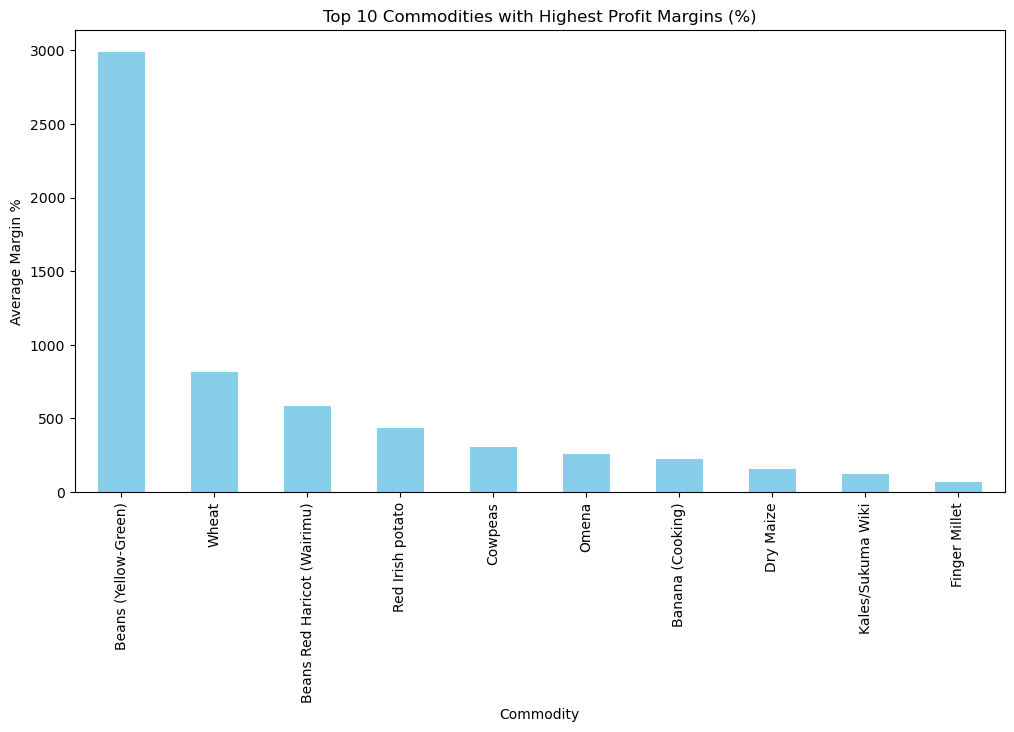

In [22]:
plt.figure(figsize=(12, 6))
data.groupby('Commodity')['Margin_Percentage'].mean().sort_values(ascending=False).head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Commodities with Highest Profit Margins (%)')
plt.ylabel('Average Margin %')
plt.show()

**Yellow-Green beans makes the highest profit margin**

#### Which are Top 10 Counties by Total Supply Volume?

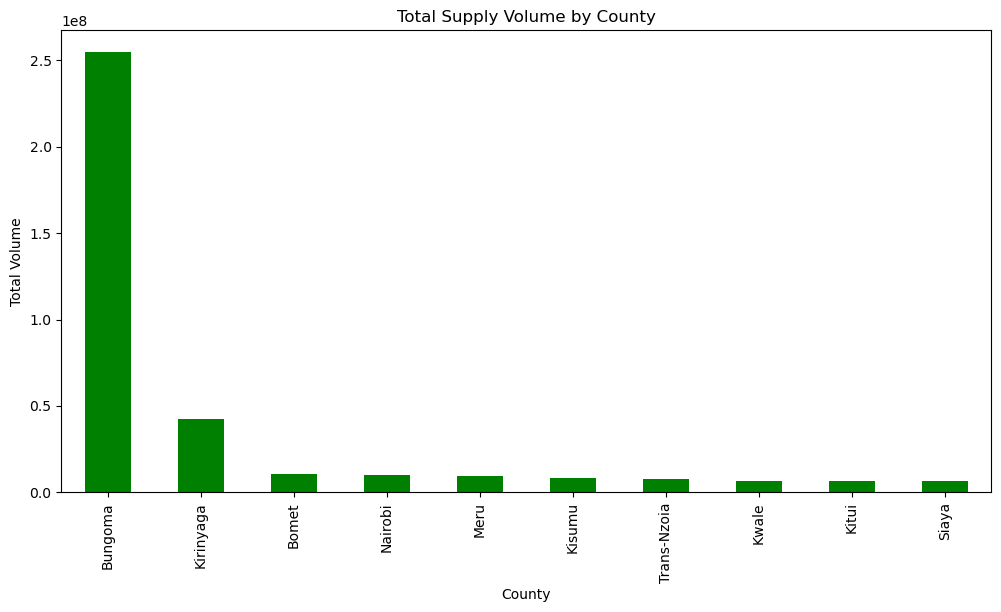

In [23]:
plt.figure(figsize=(12, 6))
data.groupby('County')['Supply Volume'].sum().sort_values(ascending=False).head(10).plot(kind='bar', color='green')
plt.title('Total Supply Volume by County')
plt.ylabel('Total Volume')
plt.show()

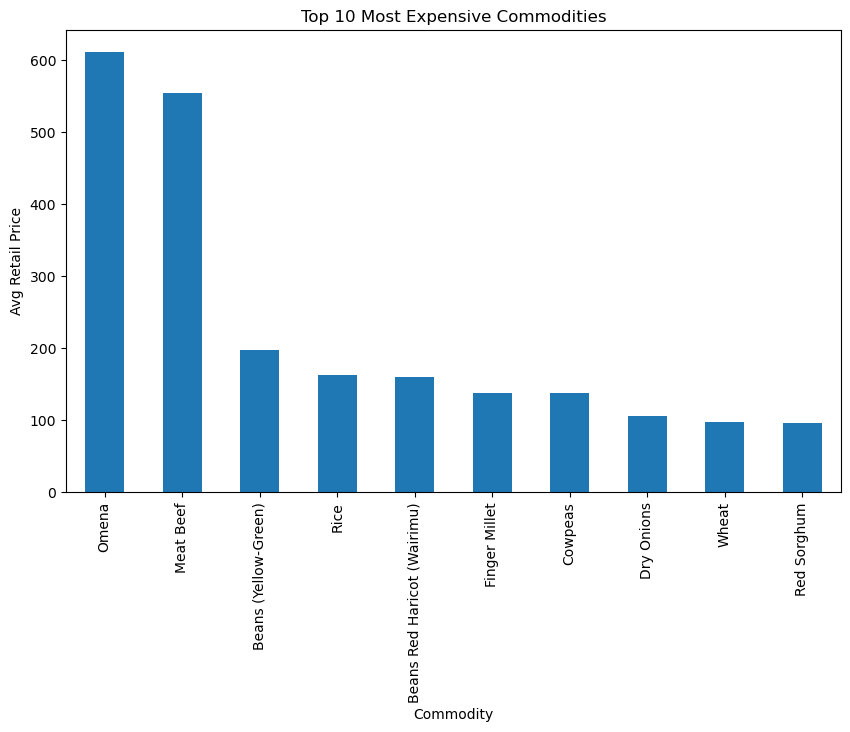

In [24]:
plt.figure(figsize=(10,6))
data.groupby('Commodity')['Retail'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
plt.ylabel("Avg Retail Price")
plt.title("Top 10 Most Expensive Commodities")
plt.show()

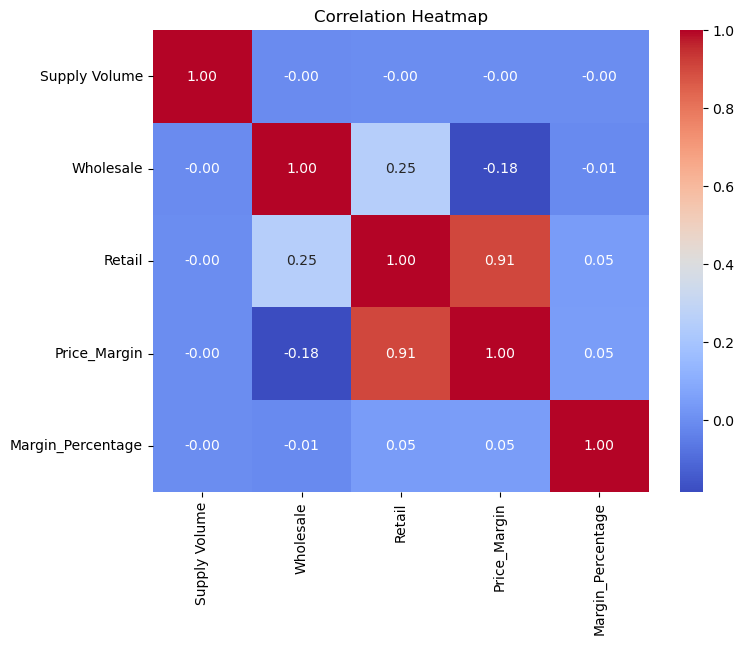

In [25]:
plt.figure(figsize=(8, 6))
correlation = data[['Supply Volume', 'Wholesale', 'Retail', 'Price_Margin', 'Margin_Percentage']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

**Supply volume have no correlation with the prices both wholesale and retail where as The price margin has a strong positive correlation of 91% with Retail prices.**

In [26]:
# Sorting data by Date and Commodity
data = data.sort_values(['Commodity', 'Date'])

# Using linear interpolation to fill gaps in price trends
data['Retail'] = data.groupby(['Market', 'Commodity'])['Retail'].transform(lambda x: x.interpolate(method='linear'))
data['Wholesale'] = data.groupby(['Market', 'Commodity'])['Wholesale'].transform(lambda x: x.interpolate(method='linear'))

In [27]:
# Calculate Coefficient of Variation - a measure of volatility
volatility = data.groupby(['Market', 'Commodity'])['Retail'].std() / data.groupby('Commodity')['Retail'].mean()
print("Top 5 Most Volatile Commodities (Hardest to predict):")
print(volatility.sort_values(ascending=False).head())

Top 5 Most Volatile Commodities (Hardest to predict):
Market                    Commodity                  
Lungalunga                Banana (Cooking)               61.967454
                          Dry Maize                      35.350013
Chepterit Market - Nandi  Dry Maize                      21.463823
Musoli Market             Beans Red Haricot (Wairimu)    18.775163
Nyamakima                 Wheat                          18.608361
Name: Retail, dtype: float64


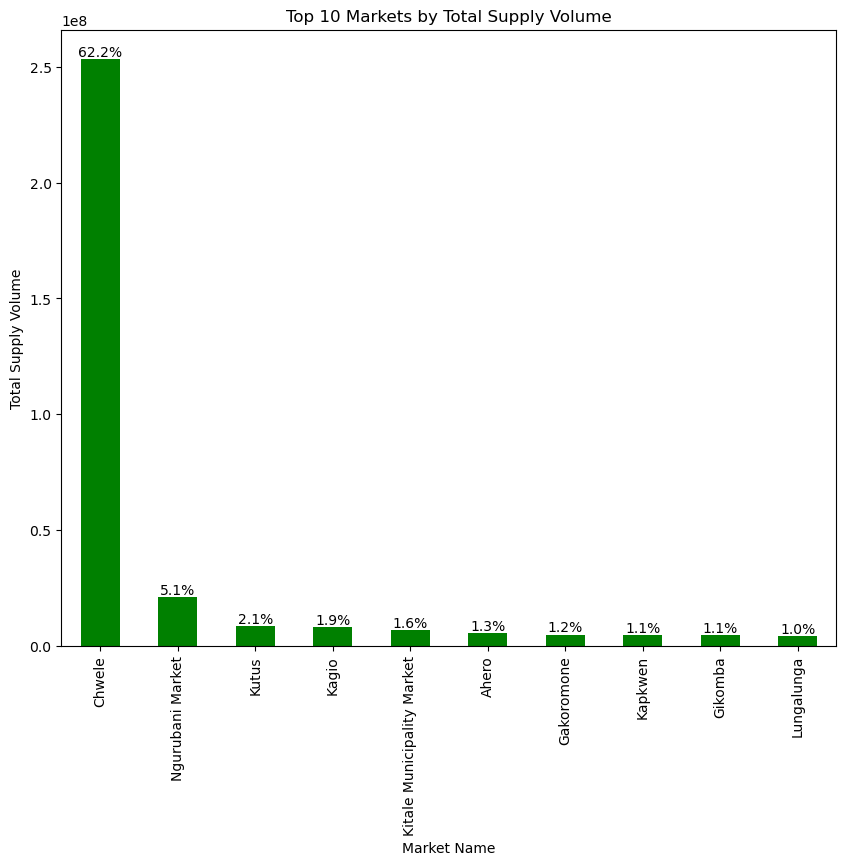

In [28]:
plt.figure(figsize=(10,8))
df1 = data.groupby('Market')['Supply Volume'].sum().sort_values(ascending=False)
df1.head(10).plot(kind='bar', color='green')
plt.xlabel("Market Name")
plt.ylabel("Total Supply Volume")
plt.title('Top 10 Markets by Total Supply Volume')
total = data.groupby('Market')['Supply Volume'].sum().sum()
for i, rate in enumerate(df1.head(10)):
   plt.text(
        i,
        rate,
        f"{rate/total:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    );

In [29]:
# Creating a list of markets for major cities
Nairobi_data = data[data['County'].str.contains('Nairobi', case=False, na=False)]


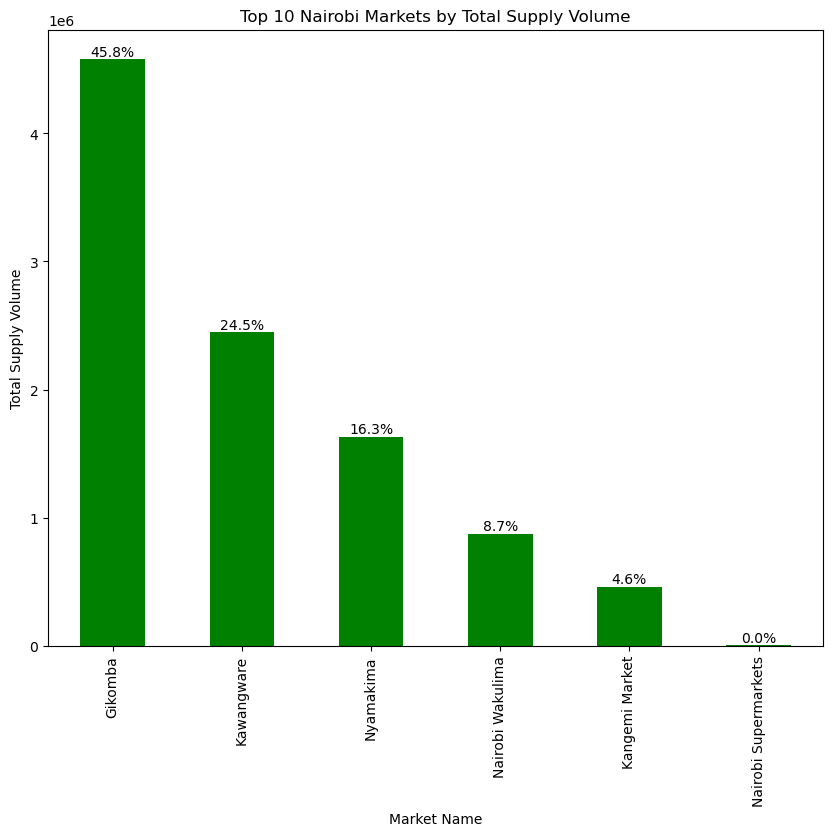

In [30]:
plt.figure(figsize=(10,8))
df2=Nairobi_data.groupby('Market')['Supply Volume'].sum().sort_values(ascending=False)
df2.head(10).plot(kind='bar', color='green')
plt.xlabel("Market Name")
plt.ylabel("Total Supply Volume")
plt.title('Top 10 Nairobi Markets by Total Supply Volume')
total = Nairobi_data.groupby('Market')['Supply Volume'].sum().sum()
for i, rate in enumerate(df2.head(10)):
   plt.text(
        i,
        rate,
        f"{rate/total:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    );

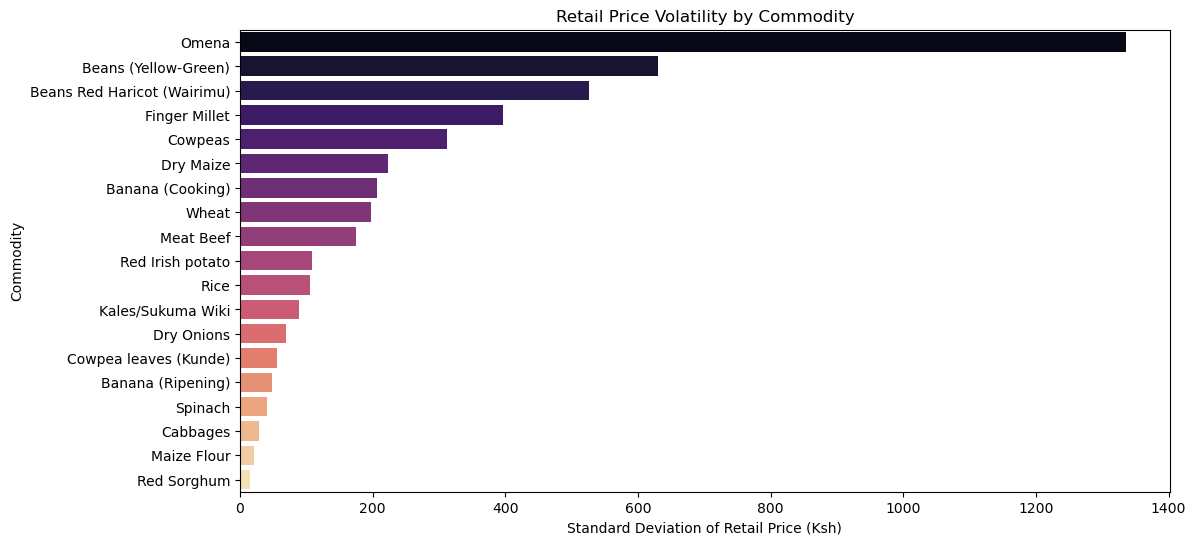

In [31]:
# Compute Volatility per Commodity 
volatility = data.groupby('Commodity')['Retail'].std().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=volatility.values, y=volatility.index, palette="magma")
plt.title("Retail Price Volatility by Commodity")
plt.xlabel("Standard Deviation of Retail Price (Ksh)")
plt.ylabel("Commodity")
plt.show()

Modelling

In [32]:
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values("Date")

In [33]:
data['day_of_week'] = data['Date'].dt.dayofweek
data['month'] = data['Date'].dt.month
data['week_of_year'] = data['Date'].dt.isocalendar().week.astype(int)
data["day_of_month"] = data['Date'].dt.day.astype(int)
data["day_of_year"] = data['Date'].dt.isocalendar().day.astype(int)

In [34]:
data['Commodity_code'] = data['Commodity'].astype('category').cat.codes
data['Market_code'] = data['Market'].astype('category').cat.codes
data['County_code'] = data['County'].astype('category').cat.codes

In [35]:
for lag in [1, 7, 14, 30]:
    data[f'Wholesale_lag_{lag}'] = (data.groupby(['Commodity', 'Market'])['Wholesale'].shift(lag))    
    data[f'Retail_lag_{lag}'] = (data.groupby(['Commodity', 'Market'])['Retail'].shift(lag))
    data[f"Supply_lag_{lag}"] = data.groupby(["Commodity", "Market"])["Supply Volume"].shift(lag)


In [36]:
for window in [7, 14, 30]:
	data[f"Retail_roll_mean_{window}"] = (data.groupby(['Commodity', 'Market'])['Retail'].shift(1).rolling(window).mean())
	data[f"Retail_roll_std_{window}"] = (data.groupby(["Commodity", "Market"])["Retail"].shift(1).rolling(window).std())
	data[f"Wholesale_roll_mean_{window}"] = (data.groupby(['Commodity', 'Market'])['Wholesale'].shift(1).rolling(window).mean())
	data[f"Wholesale_roll_std_{window}"] = (data.groupby(["Commodity", "Market"])["Wholesale"].shift(1).rolling(window).std())

In [37]:
data_model = data.dropna().copy()

In [38]:
data_model.columns

Index(['Commodity', 'Market', 'Wholesale', 'Retail', 'Supply Volume', 'County',
       'Date', 'Price_Margin', 'Margin_Percentage', 'day_of_week', 'month',
       'week_of_year', 'day_of_month', 'day_of_year', 'Commodity_code',
       'Market_code', 'County_code', 'Wholesale_lag_1', 'Retail_lag_1',
       'Supply_lag_1', 'Wholesale_lag_7', 'Retail_lag_7', 'Supply_lag_7',
       'Wholesale_lag_14', 'Retail_lag_14', 'Supply_lag_14',
       'Wholesale_lag_30', 'Retail_lag_30', 'Supply_lag_30',
       'Retail_roll_mean_7', 'Retail_roll_std_7', 'Wholesale_roll_mean_7',
       'Wholesale_roll_std_7', 'Retail_roll_mean_14', 'Retail_roll_std_14',
       'Wholesale_roll_mean_14', 'Wholesale_roll_std_14',
       'Retail_roll_mean_30', 'Retail_roll_std_30', 'Wholesale_roll_mean_30',
       'Wholesale_roll_std_30'],
      dtype='object')

In [39]:
data_model = data_model.sort_values("Date")

split_date = data_model["Date"].quantile(0.8)
train = data_model[data_model["Date"] <= split_date]
test  = data_model[data_model["Date"] > split_date]

print("Train range:", train["Date"].min(), "to", train["Date"].max(), "rows:", len(train))
print("Test range:", test["Date"].min(), "to", test["Date"].max(), "rows:", len(test))

Train range: 2022-04-11 00:00:00 to 2025-11-12 00:00:00 rows: 10708
Test range: 2025-11-13 00:00:00 to 2026-02-11 00:00:00 rows: 2647


In [40]:
feature_cols = data_model.drop(columns=["Commodity", "Market", "County", "Date", "Retail", "Margin_Percentage", "Price_Margin", "Wholesale"]).columns
X = data_model[feature_cols]
y_retail = data_model['Retail']
y_wholesale = data_model['Wholesale']

In [41]:
X_train_xgb = train[feature_cols]
X_test_xgb = test[feature_cols]

In [42]:
y_train_xgb_r = train["Retail"]
y_test_xgb_r  = test["Retail"]

In [43]:
y_train_xgb_w = train["Wholesale"]
y_test_xgb_w  = test["Wholesale"]

In [44]:
#X_train_xgb_r, X_test_xgb_r, y_train_xgb_r, y_test_xgb_r = train_test_split(X, y_retail, test_size=0.2, shuffle = False)

In [45]:
#X_train_xgb_r, X_test_xgb_r, y_train_xgb_w, y_test_xgb_w = train_test_split(X, y_wholesale, test_size=0.2, shuffle = False)

In [46]:
xgb_model_r = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42)

In [47]:
xgb_model_w = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42)

In [48]:
xgb_model_r.fit(X_train_xgb, y_train_xgb_r)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [49]:
xgb_model_w.fit(X_train_xgb, y_train_xgb_w)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [50]:
xgb_predictions_r = xgb_model_r.predict(X_test_xgb)

In [51]:
xgb_predictions_w = xgb_model_w.predict(X_test_xgb)


In [52]:
xgb_mae_r = mean_absolute_error(y_test_xgb_r, xgb_predictions_r)
print(f"MAE_R: {xgb_mae_r:.4f}")
xgb_rmse_r = np.sqrt(mean_squared_error(y_test_xgb_r, xgb_predictions_r))
print(f"RMSE_R:	{xgb_rmse_r:.4f}")


MAE_R: 18.1304
RMSE_R:	62.6866


In [53]:
(y_test_xgb_r <= 1).sum(), len(y_test_xgb_r)

(np.int64(56), 2647)

In [54]:
xgb_mae_w = mean_absolute_error(y_test_xgb_w, xgb_predictions_w)
print(f"MAE_W: {xgb_mae_r:.2f}")
xgb_rmse_w = np.sqrt(mean_squared_error(y_test_xgb_w, xgb_predictions_w))
print(f"RMSE_W:	{xgb_rmse_w:.2f}")


MAE_W: 18.13
RMSE_W:	104.35


In [55]:
print("y_test equal?", y_test_xgb_w.equals(y_test_xgb_r))
print("pred equal?", np.allclose(xgb_predictions_w, xgb_predictions_r))

y_test equal? False
pred equal? False


In [56]:
y_train_w_log = np.log1p(y_train_xgb_w)
y_test_w_log  = np.log1p(y_test_xgb_w)

xgb_model_w.fit(X_train_xgb, y_train_w_log)
pred_w_log = xgb_model_w.predict(X_test_xgb)
pred_w = np.expm1(pred_w_log)
xgb_mae_r = mean_absolute_error(y_test_xgb_r, xgb_predictions_r)
print(f"MAE_R: {xgb_mae_r:.4f}")
xgb_rmse_r = np.sqrt(mean_squared_error(y_test_xgb_r, xgb_predictions_r))
print(f"RMSE_R:	{xgb_rmse_r:.4f}")
xgb_mae_w = mean_absolute_error(y_test_xgb_w, xgb_predictions_w)
print(f"MAE_W: {xgb_mae_r:.2f}")
xgb_rmse_w = np.sqrt(mean_squared_error(y_test_xgb_w, xgb_predictions_w))
print(f"RMSE_W:	{xgb_rmse_w:.2f}")


MAE_R: 18.1304
RMSE_R:	62.6866
MAE_W: 18.13
RMSE_W:	104.35


In [57]:
commodity_name = "Rice"
target_col = "Retail"  

In [58]:
ts_df = data_model[data_model["Commodity"] == commodity_name]

In [59]:
ts = (ts_df.groupby("Date")[target_col].mean().resample("D").mean().ffill())
ts.head()

Date
2024-05-14    148.0
2024-05-15    148.0
2024-05-16    148.0
2024-05-17    148.0
2024-05-18    148.0
Freq: D, Name: Retail, dtype: float64

Checking stationarity

In [60]:
adf_result = adfuller(ts.dropna())
print(f"ADF stat: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")

ADF stat: -3.1788
p-value: 0.0212


In [64]:
adf_result = adfuller(ts.dropna())
print(f"ADF stat: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")

ADF stat: -3.1788
p-value: 0.0212


In [65]:
split_date = ts.index[int(len(ts) * 0.8)]

train_ts = ts[ts.index <= split_date]
test_ts  = ts[ts.index > split_date]

In [66]:
sarima_model = SARIMAX(
    train_ts,
    order=(1, 1, 1),              # p, d, q
    seasonal_order=(1, 1, 1, 7),  # P, D, Q, s (weekly)
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_results = sarima_model.fit(disp=False)
print(sarima_results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            Retail   No. Observations:                  512
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1892.280
Date:                           Fri, 20 Feb 2026   AIC                           3794.560
Time:                                   15:21:00   BIC                           3815.583
Sample:                               05-14-2024   HQIC                          3802.813
                                    - 10-07-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2017      0.031      6.421      0.000       0.140       0.263
ma.L1         -0.9437      0.020    -46.655

In [68]:
forecast = sarima_results.get_forecast(steps=len(test_ts))
pred = forecast.predicted_mean
mae = mean_absolute_error(test_ts, pred)
rmse = np.sqrt(mean_squared_error(test_ts, pred))
print(f"SARIMA {commodity_name} ({target_col})")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

SARIMA Rice (Retail)
MAE: 10.41
RMSE: 15.53


LSTM

In [69]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(ts_df[['Retail']])


In [70]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [71]:
seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

In [72]:
train_size = int(len(X) * 0.8)
X_train_lstm, X_test_lstm = X[:train_size], X[train_size:]
y_train_lstm, y_test_lstm = y[:train_size], y[train_size:]

In [73]:
print(f"X_train shape: {X_train_lstm.shape}, y_train shape: {y_train_lstm.shape}")
print(f"X_test shape: {X_test_lstm.shape}, y_test shape: {y_test_lstm.shape}")


X_train shape: (922, 60, 1), y_train shape: (922, 1)
X_test shape: (231, 60, 1), y_test shape: (231, 1)


In [74]:
model_lstm = Sequential([LSTM(50, return_sequences=True, input_shape=(seq_length, 1)), Dropout(0.2), LSTM(50, return_sequences=True), Dropout(0.2), LSTM(25), Dropout(0.2), Dense(1)])

In [75]:
model_lstm.compile(optimizer='adam', loss='mse', metrics = ['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [76]:
history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=1)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 161ms/step - loss: 0.0023 - mae: 0.0276 - val_loss: 4.3559e-04 - val_mae: 0.0157
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - loss: 0.0015 - mae: 0.0196 - val_loss: 4.9978e-04 - val_mae: 0.0159
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 0.0016 - mae: 0.0194 - val_loss: 4.3528e-04 - val_mae: 0.0164
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.0015 - mae: 0.0192 - val_loss: 4.3816e-04 - val_mae: 0.0166
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - loss: 0.0015 - mae: 0.0186 - val_loss: 4.3842e-04 - val_mae: 0.0156
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 0.0015 - mae: 0.0185 - val_loss: 4.3264e-04 - val_mae: 0.0160
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0016 - mae: 0.0198 - val_loss: 4.4415e-04 - val_mae: 0.0170
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0015 - mae: 0.0186 - val_loss: 4.3721e-04 - val_mae: 0.0166
Epoch 9/50
26/26 ━━━━━━━

In [77]:
lstm_preds= model_lstm.predict(X_test_lstm)
lstm_preds = scaler.inverse_transform(lstm_preds)
y_test_actual = scaler.inverse_transform(y_test_lstm)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step


In [78]:
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, lstm_preds))
print(f"LSTM RMSE: {rmse_lstm:.2f}")
lstm_mae = mean_absolute_error(y_test_actual, lstm_preds)
print(f"MAE: {lstm_mae:.2f}")
lstm_mape = mean_absolute_percentage_error(y_test_actual, lstm_preds)
print(f"MAPE: {lstm_mape:.2f}")

LSTM RMSE: 23.74
MAE: 17.67
MAPE: 0.12


In [79]:
forecast_steps = 30
forecast = results_sarima.get_forecast(steps=forecast_steps)
forecast_df = forecast.conf_int()
forecast_df['forecast'] = forecast.predicted_mean


NameError: name 'results_sarima' is not defined